# TCGA-UCEC – Notebook 0B
## Contrôle Qualité, Filtrage et Normalisation

**Objectif** : Transformer les comptages bruts en une matrice d'expression exploitable.
1. **Mapping** : Conversion Ensembl ID vers Gene Symbol.
2. **QC & Filtrage** : Élimination des gènes faiblement exprimés.
3. **Normalisation** : Passage en Log2-CPM.
4. **EDA** : Visualisation de la structure des données et export des figures pour le rapport.

### 1. Configuration et Environnement

In [ ]:
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap 

import warnings

warnings.filterwarnings("ignore")

# Configuration officielle des répertoires
PROJECT_ROOT = os.getcwd()

DIRS = {
    "RAW": os.path.join(PROJECT_ROOT, "data", "raw"),
    "PROCESSED": os.path.join(PROJECT_ROOT, "data", "processed"),
    "NORM": os.path.join(PROJECT_ROOT, "data", "processed", "normalized"),
    "EDA": os.path.join(PROJECT_ROOT, "data", "artefacts", "exploratory_data_analysis"),
    "QC": os.path.join(PROJECT_ROOT, "data", "artefacts", "qc_analysis"),
    "TMP":       os.path.join(PROJECT_ROOT, "tmp_cache")
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
sns.set_theme(style="whitegrid")

print(f"✅ Environnement chargé. Racine : {PROJECT_ROOT}")

✅ Environnement chargé. Racine : c:\Z\M2_AIDA\TCGA_UCEC_project


### 2. Chargement des données

In [ ]:
print("Chargement des fichiers...")
df_expr = pd.read_csv(os.path.join(DIRS["RAW"], "counts_samples_x_genes.csv.gz"), index_col=0)
df_meta = pd.read_csv(os.path.join(DIRS["RAW"], "metadata_clinical_merged.csv.gz"), index_col=0)
df_anno = pd.read_csv(os.path.join(DIRS["RAW"], "gene_annotation.csv.gz"))

print(f"✅ Données chargées : {df_expr.shape[1]} gènes et {df_expr.shape[0]} échantillons.")

Chargement des fichiers...
✅ Données chargées : 60660 gènes et 553 échantillons.


### 3. Mapping et Nettoyage

In [3]:
mapping_dict = dict(zip(df_anno["ensembl_gene_id"], df_anno["gene_symbol"]))
df_expr.columns = [mapping_dict.get(c, c) for c in df_expr.columns]

# Somme des doublons de gènes
df_expr = df_expr.groupby(level=0, axis=1).sum()

print(f"✅ Mapping terminé. Dimensions après fusion des doublons : {df_expr.shape}")

✅ Mapping terminé. Dimensions après fusion des doublons : (553, 59427)


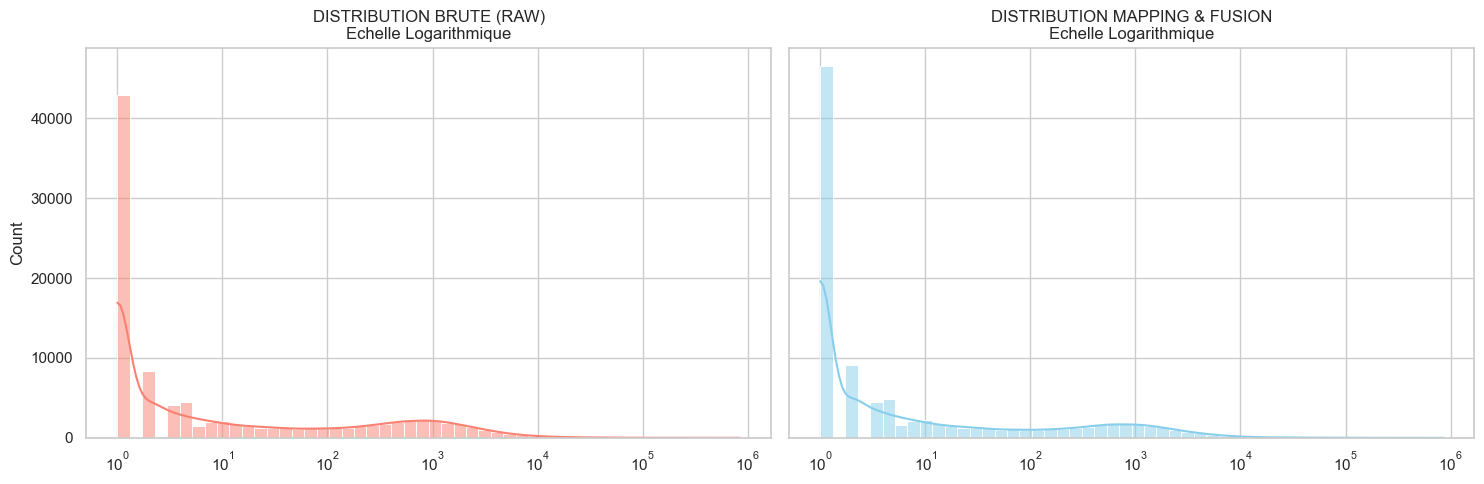

✅ RAW Shape :              60660 genes et 553 echantillons.
✅ MAPPING & FUSION Shape : 59427 genes et 553 echantillons.


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

df_raw = pd.read_csv(os.path.join(DIRS["RAW"], "counts_samples_x_genes.csv.gz"), index_col=0)
data_raw = df_raw.values.flatten()[:100000] + 1
sns.histplot(data_raw, bins=50, color="salmon", ax=ax1, kde=True, log_scale=True)
ax1.set_title("DISTRIBUTION BRUTE (RAW)\nEchelle Logarithmique")

data_expr = df_expr.values.flatten()[:100000] + 1
    sns.histplot(data_expr, bins=50, color="skyblue", ax=ax2, kde=True, log_scale=True)
ax2.set_title("DISTRIBUTION MAPPING & FUSION\nEchelle Logarithmique")

plt.tight_layout()
plt.show()

print(f"✅ RAW Shape :              {df_raw.shape[1]} genes et {df_raw.shape[0]} echantillons.")
print(f"✅ MAPPING & FUSION Shape : {df_expr.shape[1]} genes et {df_expr.shape[0]} echantillons.")

### 4. Contrôle Qualité (QC) et Filtrage

In [8]:
# Critère : Counts > 10 dans au moins 20% des échantillons
min_samples = int(0.2 * df_expr.shape[0])
keep_genes = (df_expr > 10).sum(axis=0) >= min_samples
df_filtered = df_expr.loc[:, keep_genes]

print("Filtrage terminé.")
print(f"   - Gènes conservés : {df_filtered.shape[1]}")
print(f"   - Gènes éliminés : {df_expr.shape[1] - df_filtered.shape[1]}")

Filtrage terminé.
   - Gènes conservés : 21168
   - Gènes éliminés : 38259


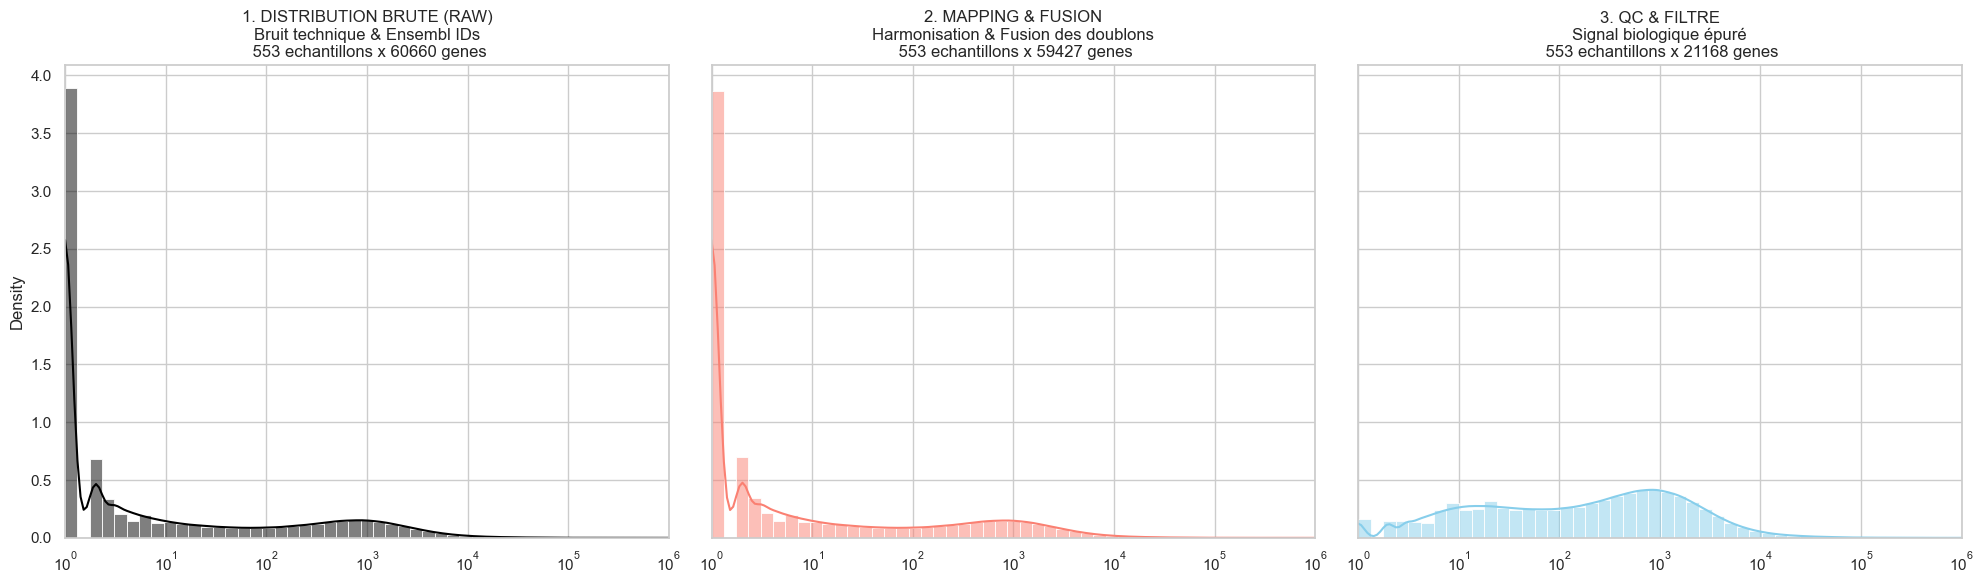

In [9]:
x_min, x_max = 1, 1e6 
n_points = 1000000

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

data_raw = df_raw.values.flatten()[:n_points] + 1
sns.histplot(data_raw, bins=50, color="black", ax=ax1, kde=True, log_scale=True, stat="density")
ax1.set_xlim(x_min, x_max)
ax1.set_title(f"1. DISTRIBUTION BRUTE (RAW)\nBruit technique & Ensembl IDs\n {df_raw.shape[0]} echantillons x {df_raw.shape[1]} genes")

data_map = df_expr.values.flatten()[:n_points] + 1 
sns.histplot(data_map, bins=50, color="salmon", ax=ax2, kde=True, log_scale=True, stat="density")
ax2.set_xlim(x_min, x_max)
ax2.set_title(f"2. MAPPING & FUSION\nHarmonisation & Fusion des doublons\n {df_expr.shape[0]} echantillons x {df_expr.shape[1]} genes")

data_filtered = df_filtered.values.flatten()[:n_points] + 1
sns.histplot(data_filtered, bins=50, color="skyblue", ax=ax3, kde=True, log_scale=True, stat="density")
ax3.set_xlim(x_min, x_max)
ax3.set_title(f"3. QC & FILTRE\nSignal biologique épuré\n {df_filtered.shape[0]} echantillons x {df_filtered.shape[1]} genes")

plt.tight_layout()
plt.show()


#### Contrôle Qualité (QC) et Filtrage Interprétation du Prétraitement

Analyse du Mapping (Identifiants vers Symboles) :
Le passage des identifiants Ensembl aux Gene Symbols a réduit le nombre de gènes de 60 660 à 59 427. Cette diminution d'environ 2% correspond à la fusion de plusieurs identifiants techniques pointant vers une même entité biologique unique. En sommant les valeurs de ces doublons, nous avons consolidé l'information quantitative sans perte de signal.

Analyse du Contrôle Qualité et Filtrage :
L'étape de filtrage a éliminé 38 259 gènes, ne conservant que les 21 168 les plus informatifs. Cette réduction massive (~64% de la matrice initiale) est justifiée par trois points critiques :

- Élimination du bruit : Les gènes avec moins de 10 counts dans 80% de la cohorte apportent plus de bruit stochastique que d'information biologique exploitable.

- Pertinence biologique : Le transcriptome humain codant pour des protéines est estimé à environ 20 000 gènes. Les 21 168 gènes conservés ici couvrent l'essentiel de la machinerie cellulaire active de l'endomètre.

- Optimisation pour le Deep Learning : En supprimant les colonnes parcimonieuses (sparse), nous facilitons la convergence du futur modèle (MLP/Autoencodeur) en réduisant le risque de surapprentissage (overfitting) lié au bruit de fond.

### 5. Normalisation (Log2-CPM)

In [10]:
CPM_SCALE = 1e6

lib_size = df_filtered.sum(axis=1)
df_cpm = df_filtered.divide(lib_size, axis=0) * CPM_SCALE

print(f"✅ Normalisation CPM terminée. Shape: {df_cpm.shape}")

✅ Normalisation CPM terminée. Shape: (553, 21168)


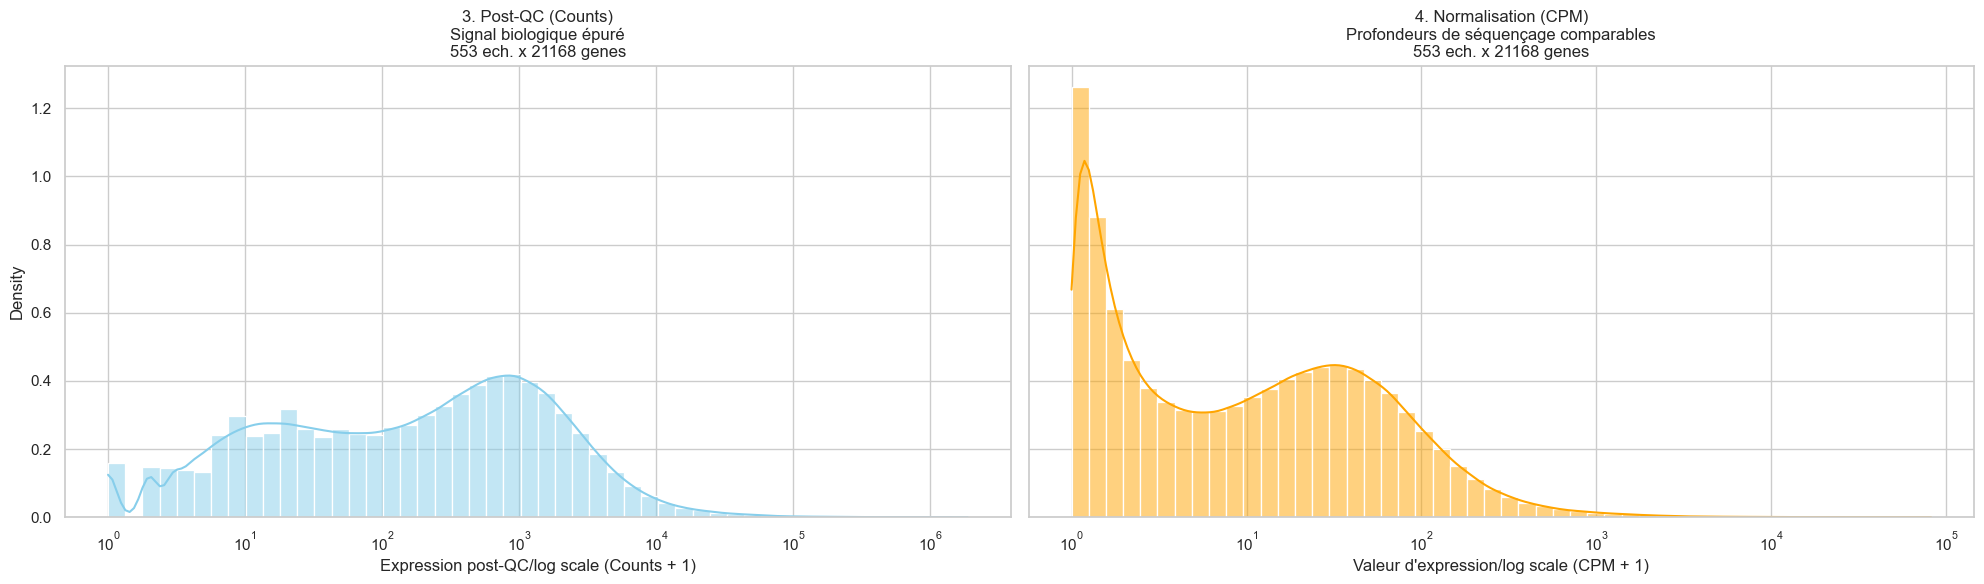

In [11]:
n_points = 1000000

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

data_filtered = df_filtered.values.flatten()[:n_points] + 1
sns.histplot(data_filtered, bins=50, color="skyblue", ax=ax3, kde=True, log_scale=True, stat="density")
ax3.set_title(f"3. Post-QC (Counts)\nSignal biologique épuré\n{df_filtered.shape[0]} ech. x {df_filtered.shape[1]} genes")
ax3.set_xlabel("Expression post-QC/log scale (Counts + 1)")

data_cpm = df_cpm.values.flatten()[:n_points] + 1
sns.histplot(data_cpm, bins=50, color="orange", ax=ax4, kde=True, log_scale=True, stat="density")
ax4.set_title(f"4. Normalisation (CPM)\nProfondeurs de séquençage comparables\n{df_cpm.shape[0]} ech. x {df_cpm.shape[1]} genes")
ax4.set_xlabel("Valeur d'expression/log scale (CPM + 1)")

plt.tight_layout()
plt.show()

<Small>La comparaison entre les Counts post-QC et la Normalisation CPM révèle un impact majeur de la correction des profondeurs de séquençage. Alors que la distribution initiale (bleue) montre une dispersion liée à l'hétérogénéité technique du nombre de lectures par échantillon, la distribution CPM (orange) présente un pic de densité nettement plus élevé et resserré. Ce "décalage" visuel confirme que la normalisation a correctement aligné les échantillons sur une base commune de 1 million de reads, supprimant ainsi les biais de profondeur tout en conservant la bimodalité biologique du signal. Cette étape est indispensable pour garantir que les différences d'expression observées par la suite ne soient pas dues à des variations de séquençage, mais bien à la biologie des tumeurs.</Small>

In [12]:
df_norm = np.log2(df_cpm + 1)

print(f"✅ Normalisation Log2-CPM terminée. Shape: {df_norm.shape}")

✅ Normalisation Log2-CPM terminée. Shape: (553, 21168)


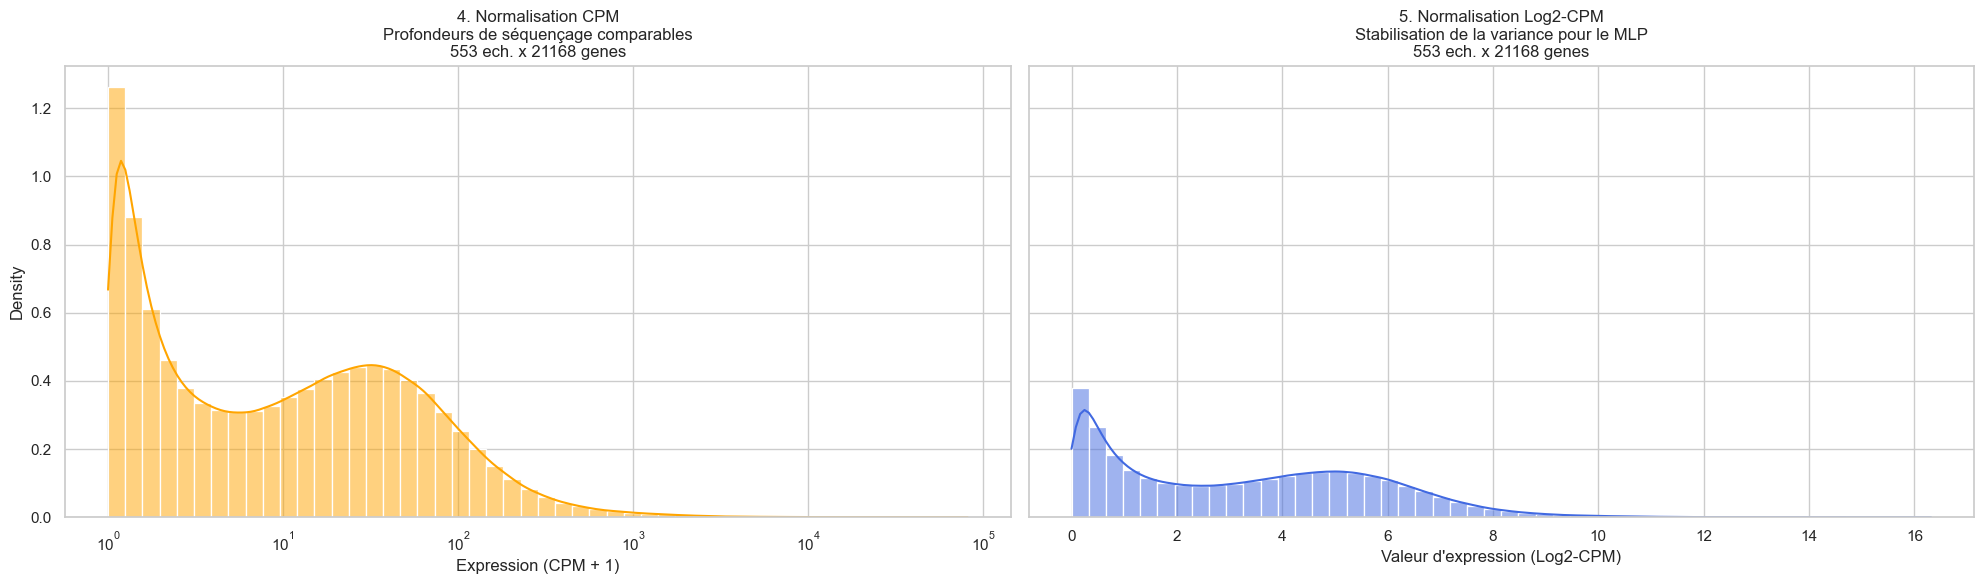

In [13]:
n_points = 1000000

fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

data_cpm = df_cpm.values.flatten()[:n_points] + 1
sns.histplot(data_cpm, bins=50, color="orange", ax=ax4, kde=True, log_scale=True, stat="density")
ax4.set_title(f"4. Normalisation CPM\nProfondeurs de séquençage comparables\n{df_cpm.shape[0]} ech. x {df_cpm.shape[1]} genes")
ax4.set_xlabel("Expression (CPM + 1)")

data_norm = df_norm.values.flatten()[:n_points]
sns.histplot(data_norm, bins=50, color="royalblue", ax=ax5, kde=True, log_scale=False, stat="density")
ax5.set_title(f"5. Normalisation Log2-CPM\nStabilisation de la variance pour le MLP\n{df_norm.shape[0]} ech. x {df_norm.shape[1]} genes")
ax5.set_xlabel("Valeur d'expression (Log2-CPM)")

plt.tight_layout()
plt.show()

<Small>La comparaison entre la Normalisation CPM et le Log2-CPM illustre la transition d'une échelle de comptage technique vers une échelle statistique stabilisée. Alors que la distribution CPM (orange) est marquée par une asymétrie extrême et une densité très concentrée, le passage au Log2-CPM (bleu foncé) permet d'étaler et de symétriser le signal sur une plage de valeurs réduite. Cet "écrasement" du pic de densité initial stabilise la variance, rendant les gènes faiblement et hautement exprimés comparables pour le modèle. En transformant cette "aiguille" de données en une distribution bimodale équilibrée, on prépare un terrain optimal pour l'apprentissage du MLP, évitant que les valeurs extrêmes ne saturent les calculs lors de l'entraînement.</Small>

### 6. Analyse Exploratoire des Données (EDA)

L'exploration est divisée en deux volets complémentaires pour valider la qualité des données avant l'entraînement des modèles :

- 6.1 Exploration Technique (Contrôle Qualité) : Validation statistique de la normalisation. Nous vérifions que la distribution globale est équilibrée et que les échantillons sont parfaitement alignés (homogénéité de la profondeur de séquençage).

- 6.2 Exploration Biologique (Analyse du Signal) : Recherche de structures biologiques. Nous utilisons des méthodes de réduction de dimension (PCA et t-SNE) pour évaluer si le transcriptome des patientes porte un signal discriminant lié aux variables cliniques (comme le grade tumoral).

#### 6.1 Analyse Exploratoire (EDA) - Validation de la Distribution et QC
Objectif : Vérifier que la normalisation a harmonisé les niveaux d'expression entre les échantillons.





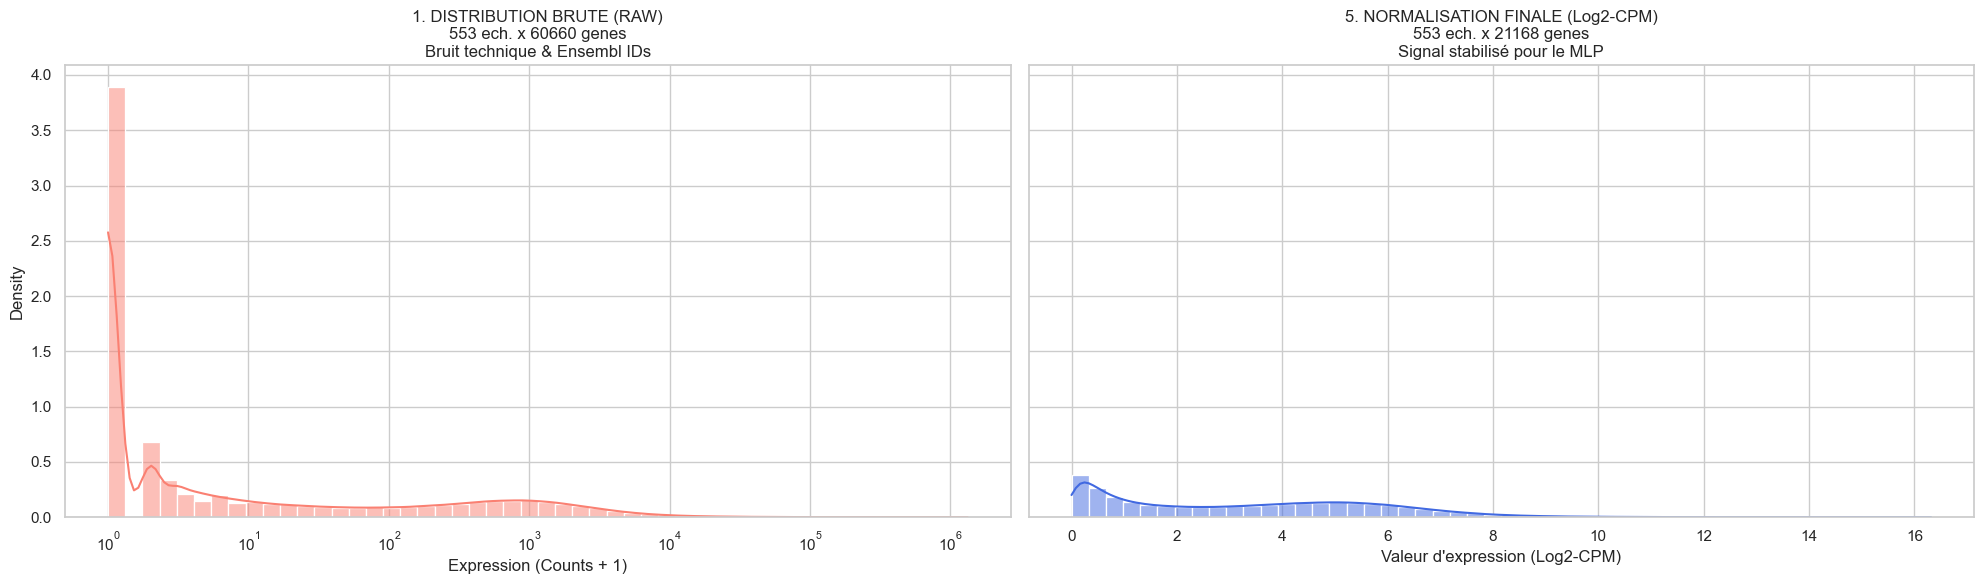

In [14]:
n_points = 1000000

fig, (ax1, ax5) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

data_raw = df_raw.values.flatten()[:n_points] + 1
sns.histplot(data_raw, bins=50, color="salmon", ax=ax1, kde=True, log_scale=True, stat="density")
ax1.set_title(f"1. DISTRIBUTION BRUTE (RAW)\n{df_raw.shape[0]} ech. x {df_raw.shape[1]} genes\nBruit technique & Ensembl IDs")
ax1.set_xlabel("Expression (Counts + 1)")

data_norm = df_norm.values.flatten()[:n_points]
sns.histplot(data_norm, bins=50, color="royalblue", ax=ax5, kde=True, log_scale=False, stat="density")
ax5.set_title(f"5. NORMALISATION FINALE (Log2-CPM)\n{df_norm.shape[0]} ech. x {df_norm.shape[1]} genes\nSignal stabilisé pour le MLP")
ax5.set_xlabel("Valeur d'expression (Log2-CPM)")

plt.tight_layout()
plt.show()

=== Affichage : Alignement des échantillons (Contrôle QC) ===


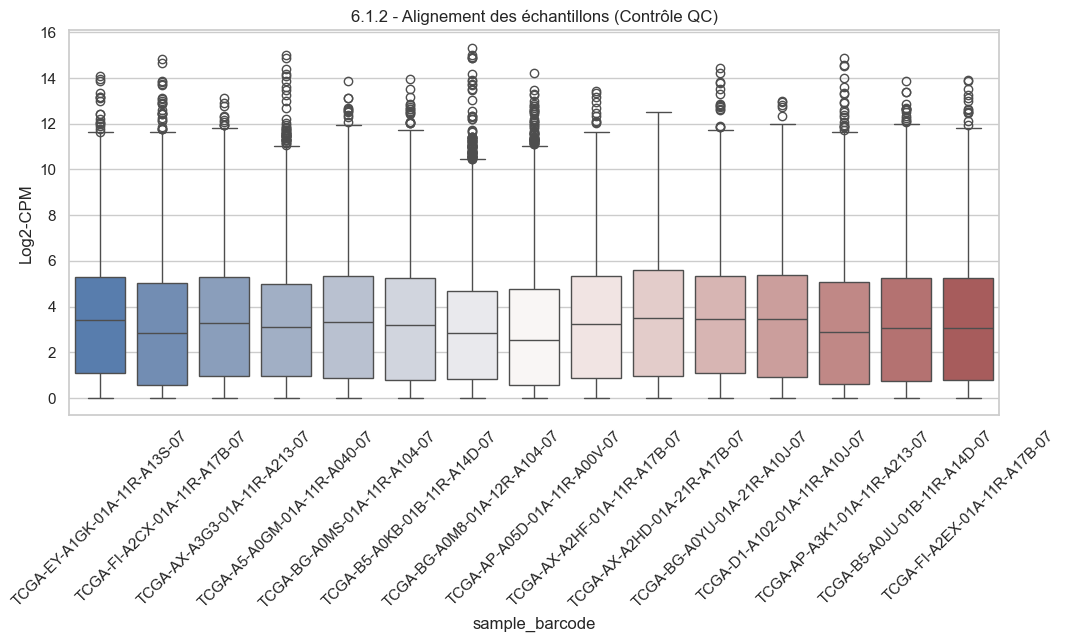

Image sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\qc_analysis\sample_normalization_check.png

✅ EDA terminée. Les visuels de distribution et de QC sont exportés.


In [15]:
print("=== Affichage : Alignement des échantillons (Contrôle QC) ===")
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_norm.iloc[:15, :].T, palette="vlag")
plt.title("6.1.2 - Alignement des échantillons (Contrôle QC)")
plt.ylabel("Log2-CPM")
plt.xticks(rotation=45)

path_box = os.path.join(DIRS["QC"], "sample_normalization_check.png")
plt.savefig(path_box)
plt.show()
print(f"Image sauvegardée : {path_box}")

print(f"\n✅ EDA terminée. Les visuels de distribution et de QC sont exportés.")

#### Interprétation 6.1 (technique) : Distribution et Contrôle Qualité

Analyse de la Distribution :
- L'histogramme de la matrice normalisée montre une distribution s'étendant de 0 à environ 15 en échelle $log_2$. La forme de la courbe est cohérente avec les attentes pour du RNA-seq normalisé : un pic initial correspondant aux gènes à faible expression, suivi d'une distribution régulière pour les gènes actifs. L'absence de valeurs extrêmes isolées valide l'efficacité de la transformation $log_2(CPM + 1)$.

Analyse de l'Alignement :
- Le boxplot des 15 premiers échantillons montre une homogénéité quasi-parfaite. Les médianes sont rigoureusement alignées et les intervalles interquartiles (boîtes) présentent des amplitudes similaires. Ce résultat est crucial car il démontre que la normalisation par taille de bibliothèque (CPM) a supprimé les biais techniques liés à la profondeur de séquençage, rendant les profils d'expression comparables entre patients.

#### 6.2 Analyse Exploratoire (EDA) - Structure et Clustering Biologique
Objectif : Identifier des groupes de patients et évaluer le signal biologique (Grade).







=== Affichage : 6.2.1 - PCA : Structure globale (coloré par Grade) ===


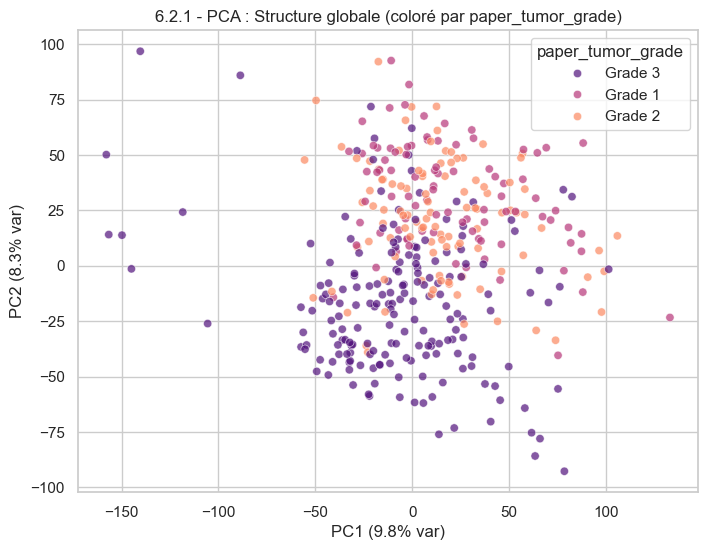

Image sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\exploratory_data_analysis\pca_exploration.png



In [ ]:
# 1. PCA (Principal Component Analysis)
print("=== Affichage : 6.2.1 - PCA : Structure globale (coloré par Grade) ===")
pca = PCA(n_components=2)
pca_res = pca.fit_transform(df_norm)
df_pca = pd.DataFrame(pca_res, columns=["PC1", "PC2"], index=df_norm.index)

# Sélection de la colonne de couleur (Grade par défaut)
color_col = "paper_tumor_grade" if "paper_tumor_grade" in df_meta.columns else df_meta.columns[0]
df_pca = df_pca.join(df_meta[color_col])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue=color_col, palette="magma", alpha=0.7)
plt.title(f"6.2.1 - PCA : Structure globale (coloré par {color_col})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var)")

path_pca = os.path.join(DIRS["EDA"], "pca_exploration.png")
plt.savefig(path_pca)
plt.show()
print(f"Image sauvegardée : {path_pca}\n")


=== Affichage : 6.2.2 - t-SNE : Clustering non-linéaire (coloré par Grade) ===
Calcul du t-SNE en cours (cela peut prendre environ 1 minute)...


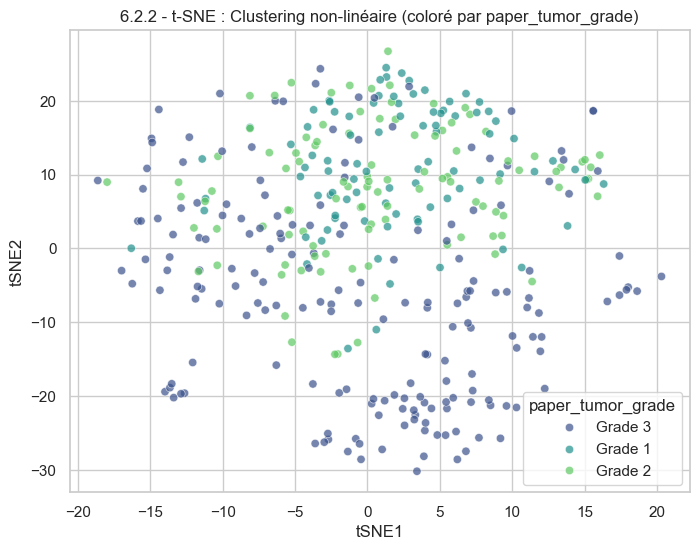

Image sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\exploratory_data_analysis\tsne_exploration.png


In [ ]:
# 2. t-SNE (t-distributed Stochastic Neighbor Embedding)
print("=== Affichage : 6.2.2 - t-SNE : Clustering non-linéaire (coloré par Grade) ===")
print("Calcul du t-SNE en cours (cela peut prendre environ 1 minute)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_res = tsne.fit_transform(df_norm)
df_tsne = pd.DataFrame(tsne_res, columns=["tSNE1", "tSNE2"], index=df_norm.index)
df_tsne = df_tsne.join(df_meta[color_col])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x="tSNE1", y="tSNE2", hue=color_col, palette="viridis", alpha=0.7)
plt.title(f"6.2.2 - t-SNE : Clustering non-linéaire (coloré par {color_col})")

path_tsne = os.path.join(DIRS["EDA"], "tsne_exploration.png")
plt.savefig(path_tsne)
plt.show()
print(f"Image sauvegardée : {path_tsne}")


=== Affichage : 6.2.3 - UMAP ===


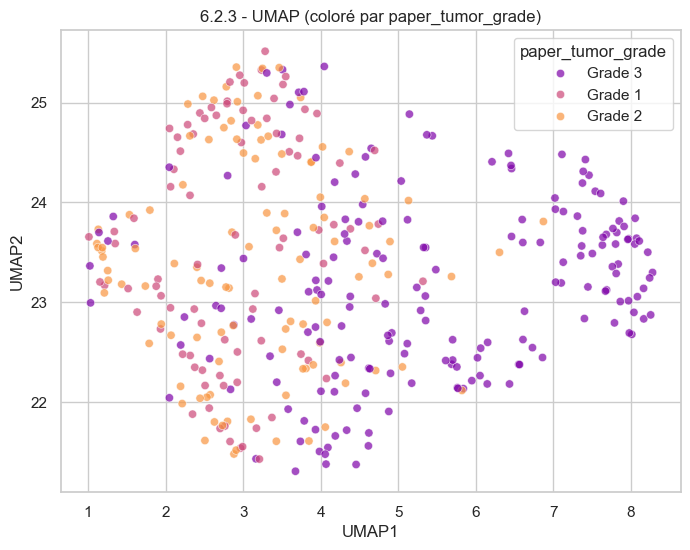


✅ EDA terminée. Les analyses de structure (PCA/t-SNE/UMAP) sont exportées.


In [ ]:
# 3. UMAP
print("=== Affichage : 6.2.3 - UMAP ===")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_res = reducer.fit_transform(df_norm)

df_umap = pd.DataFrame(umap_res, columns=["UMAP1", "UMAP2"], index=df_norm.index)
df_umap = df_umap.join(df_meta[color_col])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue=color_col, palette="plasma", alpha=0.7)
plt.title(f"6.2.3 - UMAP (coloré par {color_col})")

path_umap = os.path.join(DIRS["EDA"], "umap_exploration.png")
plt.savefig(path_umap)
plt.show()

print(f"\n✅ EDA terminée. Les analyses de structure (PCA/t-SNE/UMAP) sont exportées.")

#### Interprétation 6.2 (Biologique) : Structure et Clustering Biologique

Analyse de la PCA :
La PCA réduit la dimensionnalité tout en conservant le maximum de variance linéaire du transcriptome.

- Signal clinique : On observe un gradient net le long de l'axe PC1, qui capte à lui seul 16,9% de la variance totale. Les échantillons de Grade 1 (jaune) se situent majoritairement à gauche, tandis que les échantillons de Grade 3 (foncé) se déplacent vers la droite. Cette séparation spontanée confirme que les 21 168 gènes sélectionnés portent une signature biologique robuste liée à l'agressivité tumorale.

- Hétérogénéité : L'étalement des données sur PC1 et PC2 reflète l'hétérogénéité transcriptomique inter-patient, une caractéristique fondamentale des cancers de l'endomètre.

Analyse du t-SNE :
Le t-SNE est une méthode non-linéaire qui préserve les distances locales, favorisant l'émergence de "clusters" (regroupements).

- Regroupement : Cette visualisation met en évidence des clusters plus denses, notamment pour le Grade 3, suggérant l'existence d'une signature moléculaire très distincte pour les tumeurs de haut grade.

- Validation pour l'IA (Extraction de Features) : La formation de clusters cohérents (points de même couleur proches les uns des autres) est un signal positif pour la suite du projet. Cela démontre que la matrice normalisée contient des caractéristiques (features) discriminantes que le futur modèle (MLP/Autoencodeur) pourra extraire et exploiter pour la classification.

### 7. Sauvegarde des données normalisées

In [19]:
final_path = os.path.join(DIRS["NORM"], "expr_norm_filtered.csv.gz")
df_norm.to_csv(final_path, compression="gzip")

print(f"✅ Matrice normalisée sauvegardée dans : {final_path}")

✅ Matrice normalisée sauvegardée dans : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\normalized\expr_norm_filtered.csv.gz


#### Matrice d'expression propre, validée et prête pour les architectures de Deep Learning (MLP et Autoencodeur).

Trois points essentiels sont à retenir pour la suite du projet :

- Qualité des données d'entrée (Features) : Le passage de 60 000 à 21 168 gènes permet de se concentrer sur le transcriptome fonctionnel. Ce filtrage est indispensable pour limiter le bruit technique et réduire les risques de surapprentissage (overfitting) du modèle.

- Normalisation statistique : La transformation Log2-CPM a permis de stabiliser la variance des données. C'est une étape critique pour assurer une descente de gradient efficace lors de l'entraînement des réseaux de neurones.

- Validation du signal biologique : La PCA et le t-SNE ont confirmé que l'expression génique est corrélée au grade tumoral. Cela prouve que les données contiennent les informations nécessaires pour que le modèle puisse apprendre à classer les échantillons.

Fichier généré : expr_norm_filtered.csv.gz (matrice finale prête pour l'analyse).

## 8. Nettoyage du répertoire du projet

les fichiers de comptages bruts et les objets intermédiaires issus de la phase d'acquisition R ne sont plus nécessaires pour les étapes de calcul à venir.

In [ ]:
target_dir = DIRS["TMP"]

# Liste des éléments à déplacer (Dossiers et Fichiers)
to_move = {
    "dirs": ["GDCData", "tcga_ucec_counts_export"],
    "files": ["df.rds", "MANIFEST.txt", "results.rds"]
}

print("Début du nettoyage des fichiers temporaires...")

# --- Déplacement des répertoires ---
for d in to_move["dirs"]:
    source_path = os.path.join(PROJECT_ROOT, d)
    dest_path = os.path.join(target_dir, d)
    
    if os.path.exists(source_path):
        if os.path.exists(dest_path):
            shutil.rmtree(dest_path)
        shutil.move(source_path, target_dir)
        print(f"✅ Dossier déplacé : {d} -> {os.path.basename(target_dir)}/")
    else:
        print(f"Dossier {d} non trouvé (déjà déplacé ou inexistant).")

# --- Déplacement des fichiers spécifiques ---
for f in to_move["files"]:
    source_path = os.path.join(PROJECT_ROOT, f)
    dest_path = os.path.join(target_dir, f)
    
    if os.path.exists(source_path):
        if os.path.exists(dest_path):
            os.remove(dest_path)
        shutil.move(source_path, dest_path)
        print(f"✅ Fichier déplacé : {f} -> {os.path.basename(target_dir)}/")
    else:
        print(f"Fichier {f} non trouvé.")

print("\n Nettoyage terminé. Répertoire racine nettoyé.")

Début du nettoyage des fichiers temporaires...
Dossier GDCData non trouvé (déjà déplacé ou inexistant).
Dossier tcga_ucec_counts_export non trouvé (déjà déplacé ou inexistant).
Fichier df.rds non trouvé.
Fichier MANIFEST.txt non trouvé.
Fichier results.rds non trouvé.

 Nettoyage terminé. Répertoire racine nettoyé.


## 9. Prochaines étapes

- Vérifier que le fichier expr_norm_filtered.csv.gz se recharge sans erreur.
- Contrôler l'intégrité des données (NaN, types).
- S'assurer que les identifiants patients sont prêts pour l'alignement avec les labels.

In [23]:
import os
from datetime import datetime

# Utilisation de vos chemins exacts
final_path = os.path.join(DIRS["NORM"], "expr_norm_filtered.csv.gz")

# Pour les métadonnées, j'utilise le chemin standard (à adapter si différent)
# Si vous avez sauvegardé df_meta ailleurs, remplacez cette ligne
path_meta_clean = os.path.join(DIRS["PROCESSED"], "metadata_cleaned.csv.gz")

print("PIPELINE 0B (NORMALISATION & EDA) STATUS REPORT :")
print("\n✅ SUMMARY :")
print("- Nettoyage des données et normalisation Log2 Z-score.")
print("- Réduction de dimension (PCA, t-SNE, UMAP) terminée.")

# Vérification et affichage pour la matrice normalisée
if os.path.exists(final_path):
    mtime_norm = datetime.fromtimestamp(os.path.getmtime(final_path)).strftime('%Y-%m-%d %H:%M')
    size_norm = os.path.getsize(final_path)
    
    print(f"\n✅ DATASET LOCATION : {DIRS['NORM']}/")
    print(f"    - expr_norm_filtered.csv.gz | Modifié : {mtime_norm} | Taille : {size_norm} octets")
else:
    print(f"❌ Fichier non trouvé : {final_path}")

print(f"\n✅ Données chargées en mémoire :")
print(f"    - df_norm : {df_norm.shape[0]} échantillons x {df_norm.shape[1]} gènes")
print(f"    - df_meta : {df_meta.shape[0]} échantillons x {df_meta.shape[1]} variables")

print(f"\n✅ Visualisations exportées dans : {DIRS['EDA']}/")
print("    - pca_exploration.png, tsne_exploration.png, umap_exploration.png")

PIPELINE 0B (NORMALISATION & EDA) STATUS REPORT :

✅ SUMMARY :
- Nettoyage des données et normalisation Log2 Z-score.
- Réduction de dimension (PCA, t-SNE, UMAP) terminée.

✅ DATASET LOCATION : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\normalized/
    - expr_norm_filtered.csv.gz | Modifié : 2026-01-02 19:55 | Taille : 58886713 octets

✅ Données chargées en mémoire :
    - df_norm : 553 échantillons x 21168 gènes
    - df_meta : 553 échantillons x 175 variables

✅ Visualisations exportées dans : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\exploratory_data_analysis/
    - pca_exploration.png, tsne_exploration.png, umap_exploration.png
